In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


# DATA WRANGLING & CLEANING

First we'll load the data associated with the average working hours by country

In [2]:
hrs_work = pd.read_csv('hours_worked.csv') #a dataset of the annual average working hours based on country over the last 4 years.
hrs_work = hrs_work[['LOCATION','TIME','Value','SUBJECT']]
hrs_work = hrs_work.query('SUBJECT =="TOT" and TIME == 2020 or TIME ==2019 or TIME ==2018 or TIME ==2017')
hrs_work.head()



,LOCATION,TIME,Value,SUBJECT
32,AUS,2017,1738.0,TOT
33,AUS,2018,1733.0,TOT
34,AUS,2019,1722.0,TOT
35,AUS,2020,1683.0,TOT
58,AUT,2017,1498.0,TOT


Then we'll add the data associated with the GDP and merge them together

In [3]:
gdp_hrs = pd.read_csv('gdp_hrs.csv') #a dataset of the GDP per country over the last 4 years
gdp_hrs = gdp_hrs[['LOCATION','Country','TIME','Subject','Value','MEASURE','Measure']]
gdp_hrs = gdp_hrs.query('TIME == 2020 or TIME == 2019 or TIME ==2018 or TIME ==2017')
gdp_hrs['GDP'] = gdp_hrs.query('Subject == "Gross Domestic Product (GDP); millions"')['Value']
gdp_hrs.drop('Subject',axis =1,inplace=True)
gdp_hrs.drop('Value',axis =1,inplace=True)
df = gdp_hrs.query('Measure == "USD, current prices, current PPPs"')[['LOCATION','Country','TIME','GDP']] 
#a new dataset where I merge the GDP and the average working hours on the location and the year of the statistics.
df.dropna(inplace=True)
df = pd.merge(df,hrs_work,how='inner',on=['LOCATION','TIME'])
df.drop('SUBJECT',axis=1,inplace=True)
df = df.rename(columns = {'Value' : 'Hours' , 'TIME' : 'Year'})
df.head()



,LOCATION,Country,Year,GDP,Hours
0,AUS,Australia,2017,1251095.561,1738.0
1,AUS,Australia,2018,1326164.114,1733.0
2,AUS,Australia,2019,1346385.112,1722.0
3,AUS,Australia,2020,1329644.452,1683.0
4,AUT,Austria,2017,476563.995,1498.0


Then We'll load the data associated with the unemployment rate and merge it with the rest.

In [4]:
emp = pd.read_csv('unemployment.csv') #a dataset of the unemployment rate by country over the last 4 years.
emp = emp.query("MEASURE =='PC_LF' and FREQUENCY =='A' and TIME =='2020' or TIME =='2019' or TIME == '2018' or TIME =='2017'")
emp = emp.query("SUBJECT =='TOT'")
emp = emp[['LOCATION', 'TIME', 'Value']]
emp = emp.rename(columns = {'TIME':'Year','Value':'Unemployment'})
emp['Year'] = pd.to_numeric(emp['Year'])
df = pd.merge(df,emp,how='inner',on=['LOCATION','Year']) #merge it with the previous dataframe
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
df= df.query('Country != "OECD - Total"')
df.head()


,LOCATION,Country,Year,GDP,Hours,Unemployment
0,AUS,Australia,2017,1251095.561,1738.0,5.593760
1,AUS,Australia,2018,1326164.114,1733.0,5.299855
2,AUS,Australia,2019,1346385.112,1722.0,5.159017
3,AUS,Australia,2020,1329644.452,1683.0,6.464408
4,AUT,Austria,2017,476563.995,1498.0,5.925000


Then finally the data about the average wage.

In [5]:
wage = pd.read_csv('wage.csv') #a dataset of the average wages by country over the years.
wage = wage[['LOCATION','TIME','Value']]
wage = wage.query('TIME == 2017 or TIME == 2018 or TIME == 2019 or TIME ==2020')
wage = wage.rename(columns = {'TIME':'Year','Value':'Average_Wage'})
wage.head()
df = pd.merge(df,wage,how='inner',on=['LOCATION','Year'])
df.head()


,LOCATION,Country,Year,GDP,Hours,Unemployment,Average_Wage
0,AUS,Australia,2017,1251095.561,1738.0,5.593760,53437.058754
1,AUS,Australia,2018,1326164.114,1733.0,5.299855,53514.827225
2,AUS,Australia,2019,1346385.112,1722.0,5.159017,54020.791491
3,AUS,Australia,2020,1329644.452,1683.0,6.464408,55206.393664
4,AUT,Austria,2017,476563.995,1498.0,5.925000,53136.352960


# Exploring The Data

This is a collected dataset containing information about average annual working hours - GDP - average wages - Unemployment across the countries and the years these data were collected and we want to know how working hours affect all of these parameters.

# Univariate Exploration

First let's take a look at the distribution of the working hours.

In [6]:
base_color = sb.color_palette()[0]
def histo(x,title):
    '''
    Takes two string parameters to plot a histogram:
    x: x axis of the histogram
    title: The title of the plot
    '''
    plt.figure(figsize=(10,6))
    plt.hist(data=df,x=x)
    plt.title(title)

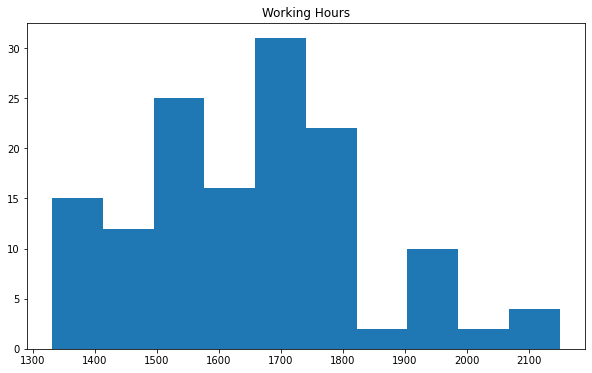

In [7]:
histo('Hours','Working Hours')

Now we can see that there's no specific pattern in the data, itsn't normally distributed nor is it skewed, but we can see that the most frequent are the average near the middle, with the lowest not being the least frequent but near the max number of hours.

Now let's take a look at the distribution of the GDP.

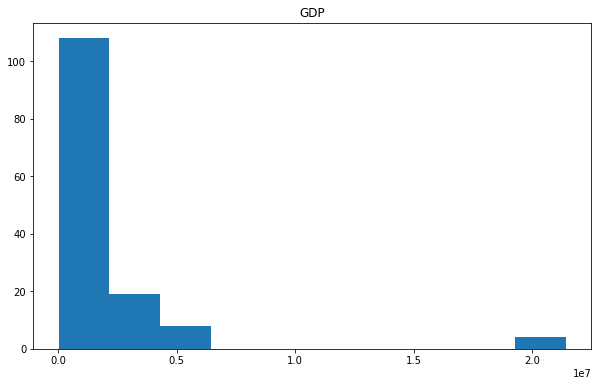

In [8]:
histo('GDP','GDP')

It's very clear that there's an oulier in the total GDP that needs more investigation to understand amd it can't be ignored.

Now let's check the distribution of unemployment rates.

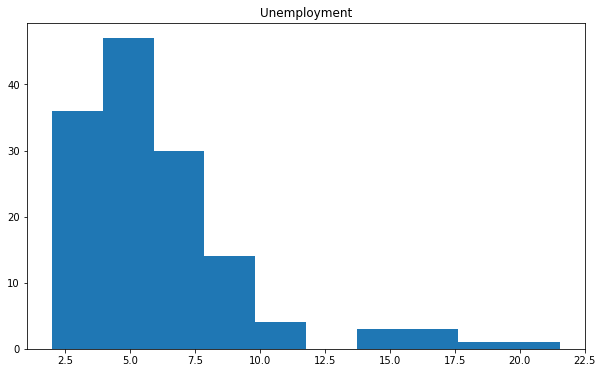

In [9]:
histo('Unemployment','Unemployment')

We can see here that the majority of the rates lie between 2.5 and 10 % but there's a huge portion a bit bigger and they can't be ignored at all. We should investigate about it more.

So what about the average wages?

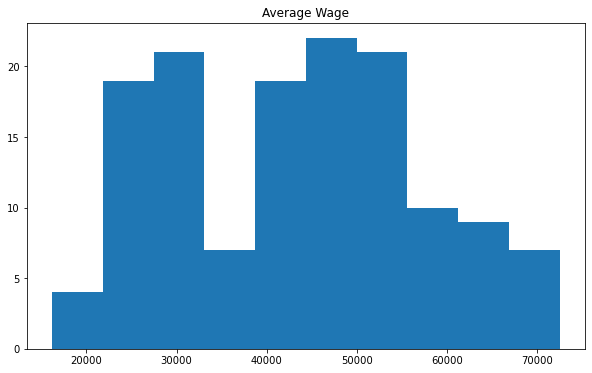

In [10]:
histo('Average_Wage','Average Wage')

The wages have sharp increase/decreases with a low number of wages between 30k and 40k USD then taking a very big climb till it falls sharply.

# Bivariate Exploration

Now let's look at the relationships between each parameter and the other.

So what's the relationship between GDP and unemployment?

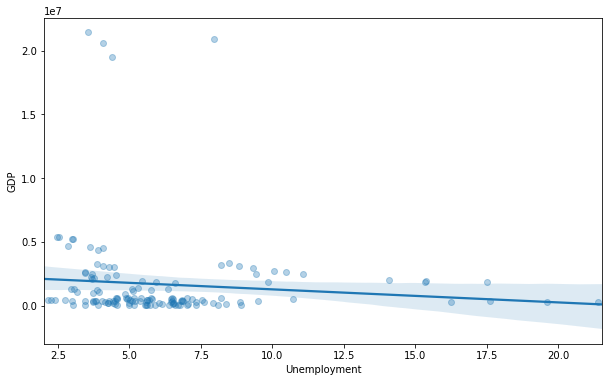

In [12]:
plt.figure(figsize=(10,6));
sb.regplot(data=df,y='GDP',x='Unemployment',x_jitter=0.3,scatter_kws={'alpha' :1/3});

Here we can see as expected. The GDP has negative correlation with the unemployment which means that as unemployment increases, the GDP decreases.

 So what about the relationship between the wages and the GDP?

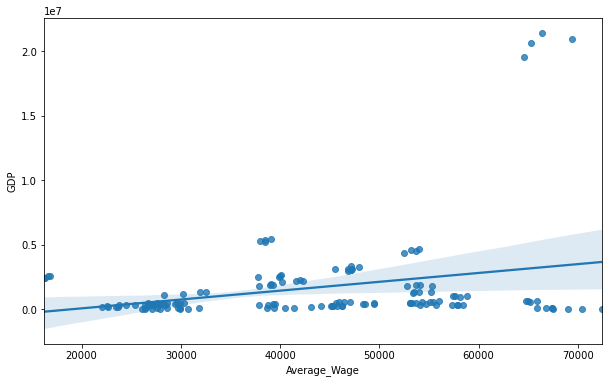

In [18]:
plt.figure(figsize=(10,6));
sb.regplot(data=df,y='GDP',x='Average_Wage');

Here we can also see a very strange pattern where the Lowest and the highest GDP pay the highest average wages with the lowest average wage coming near or after the third quartile!

So what about the working hours? How does it affect the unemployment rate?

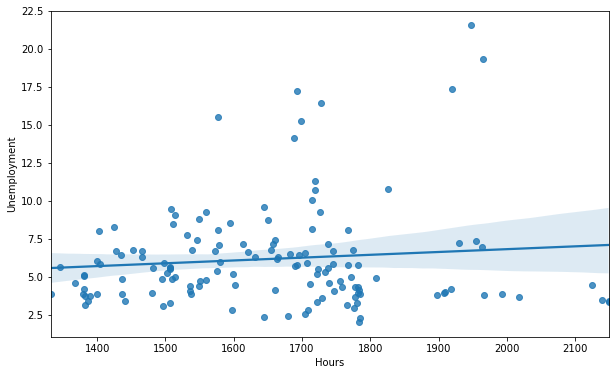

In [14]:
plt.figure(figsize=(10,6));
sb.regplot(data=df,x='Hours',y='Unemployment');

A positive correlation between the unemployment rate and the number of working hours suggesting that as number of hours per employee increases the unemployment rate increases as well.

So what about the working hours and the GDP?

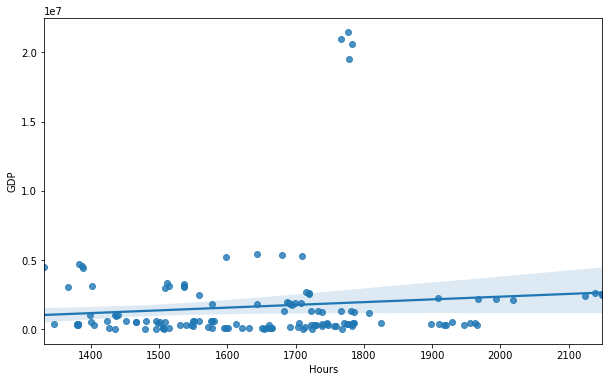

In [15]:
plt.figure(figsize=(10,6));
sb.regplot(data=df,y='GDP',x='Hours');

the working hours has a positive correlation with the GDP despite having a negative one with the unemployment rate but we can here notice that US is also a major outlier here with a moderate working hours so let's take a look at the distribution of working hours by countries.

We've seen how the working hours negatively affect the unemployment but what is its effect on the employed?
Let's see the relationship between the working hours and the average wages.

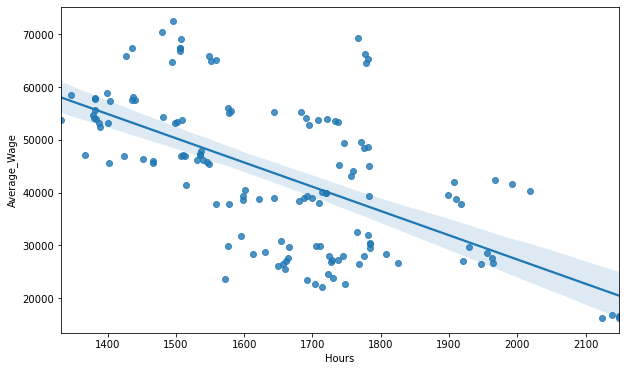

In [17]:
plt.figure(figsize=(10,6));
sb.regplot(data=df,y='Average_Wage',x='Hours');

We can now see very clearly that average wage has a negative correlation with the yearly working hours with the highest averages lie between low to moderate number of hours.

# Multivariate Exploration

After we've seen the distribution of the GDP we noticed an outlier so what's that outlier?

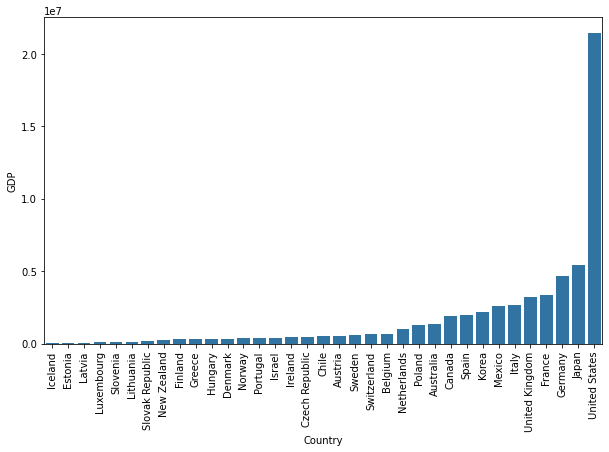

In [11]:
x = df.query('Year ==2019');
plt.figure(figsize=(10,6));
sb.barplot(data=x,x='Country',y='GDP',order=x.sort_values('GDP').Country,color=base_color);
plt.xticks(rotation=90);

Here we can see it very clear that US is the outlier and we can't ignore it we actually need to investigate it further.


As well as seeing an outlier in the GDP we also saw ouliers in the unemployment so let's look at the distribution of the unemployment by country

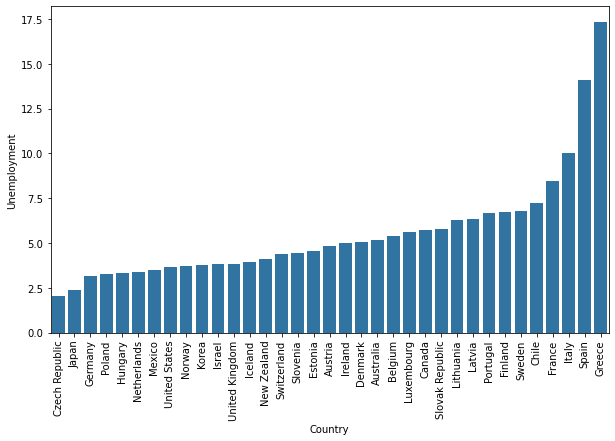

In [13]:
x = df.query('Year ==2019');
plt.figure(figsize=(10,6));
sb.barplot(data=x,x='Country',y='Unemployment',order=x.sort_values('Unemployment').Country,color=base_color);
plt.xticks(rotation=90);

From that distribution we can notice 3 points:
1- the US which had the highest GDP by far, has a low unemployment rate but not the lowest at the same time.
2 - Greece has the highest unemployment rate with a very low GDP which makes sense.
3- Spain is the second most unemployment rate but has an okay GDP
So let's investigate more

Now let's go back to the working hours, let's take a look at how it's distributed across the countries.

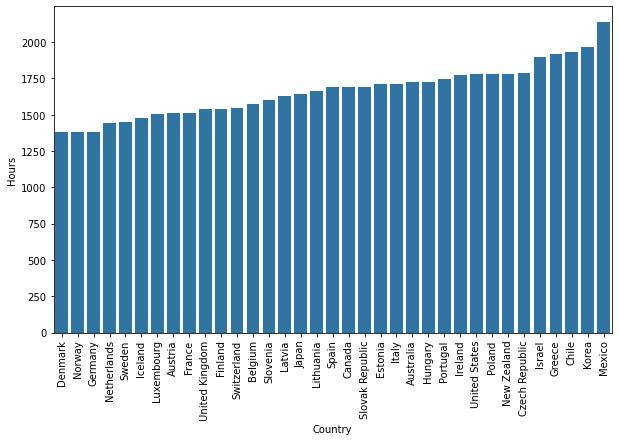

In [16]:
x = df.query('Year ==2019');
plt.figure(figsize=(10,6));
sb.barplot(data=x,x='Country',y='Hours',order=x.sort_values('Hours').Country,color=base_color);
plt.xticks(rotation=90);

Here we can see some very interesting insights, cause Greece with the highest unemployment rate and a very low GDP is the 4th most country with yearly working hours as well as Mexico being the most country with working hours with an okay GDP and a low unemployment rate.

But has it always been like that? How did it change over the years?

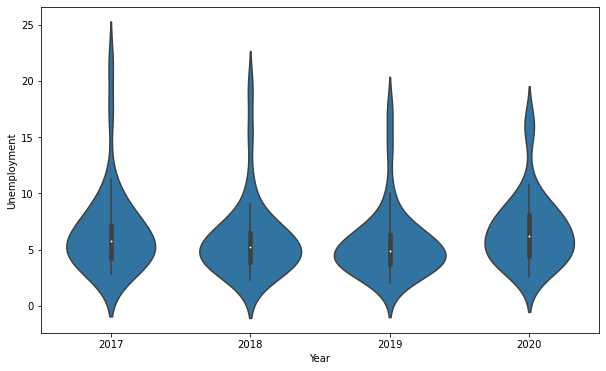

In [50]:
plt.figure(figsize=(10,6));
sb.violinplot(data=df,x='Year',y='Unemployment',inner='box',color=base_color);

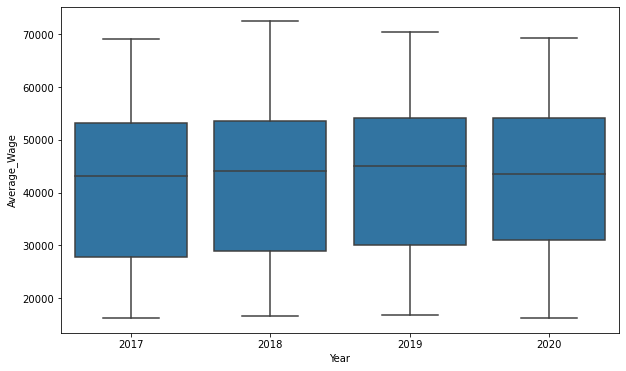

In [51]:
plt.figure(figsize=(10,6));
sb.boxplot(data=df,x='Year',y='Average_Wage',color=base_color);

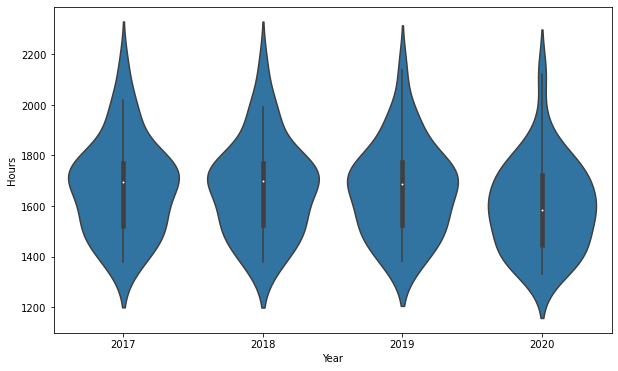

In [52]:
plt.figure(figsize=(10,6));
sb.violinplot(data=df,x='Year',y='Hours',color=base_color);

We can see that the differences across the last 3 years are not that big when it comes to both unemployment rates, average wages and working hours but for 2020 the difference can be noticed as there was a steep increase in wages and decrease in unemployment  but changed as well as a decrease in working hours surely due to the covid-19 pandemic.

Now let's look at the hours against all 3 other aspects (GDP - Unemployment - Wage) over the past 4 years.

<Figure size 720x432 with 0 Axes>

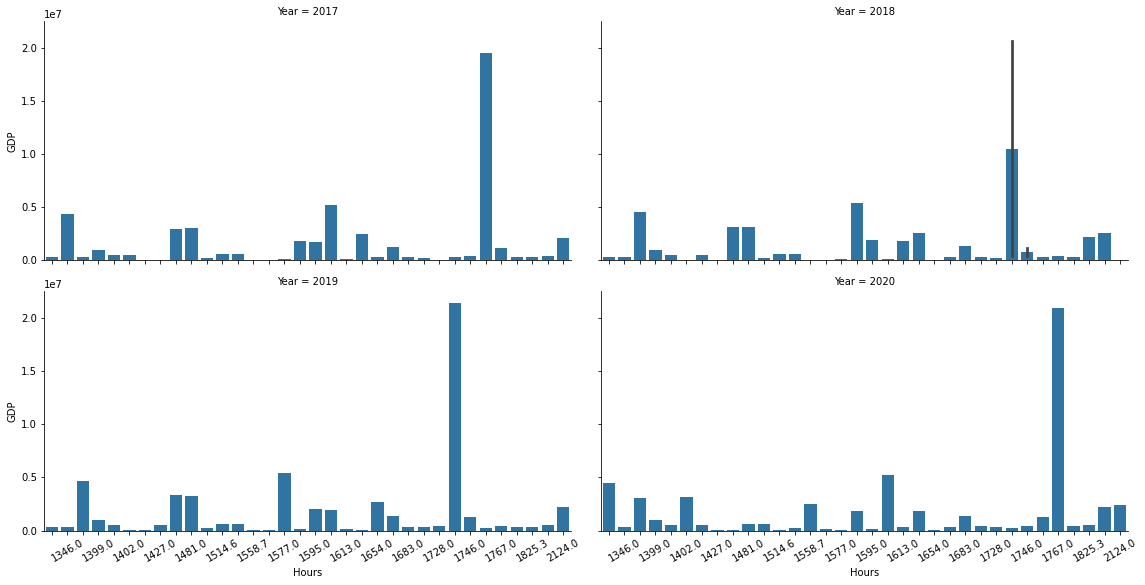

In [53]:
plt.figure(figsize=(10,6))
g = sb.FacetGrid(data=df,col='Year',col_wrap=2,size=4,aspect=2)
g.map(sb.barplot,'Hours','GDP');
for ax in g.axes.flat:
    labels = ax.get_xticklabels() # get x labels
    for i,l in enumerate(labels):
        if(i%2 == 0): labels[i] = '' # skip even labels
    ax.set_xticklabels(labels, rotation=30) # set new labels




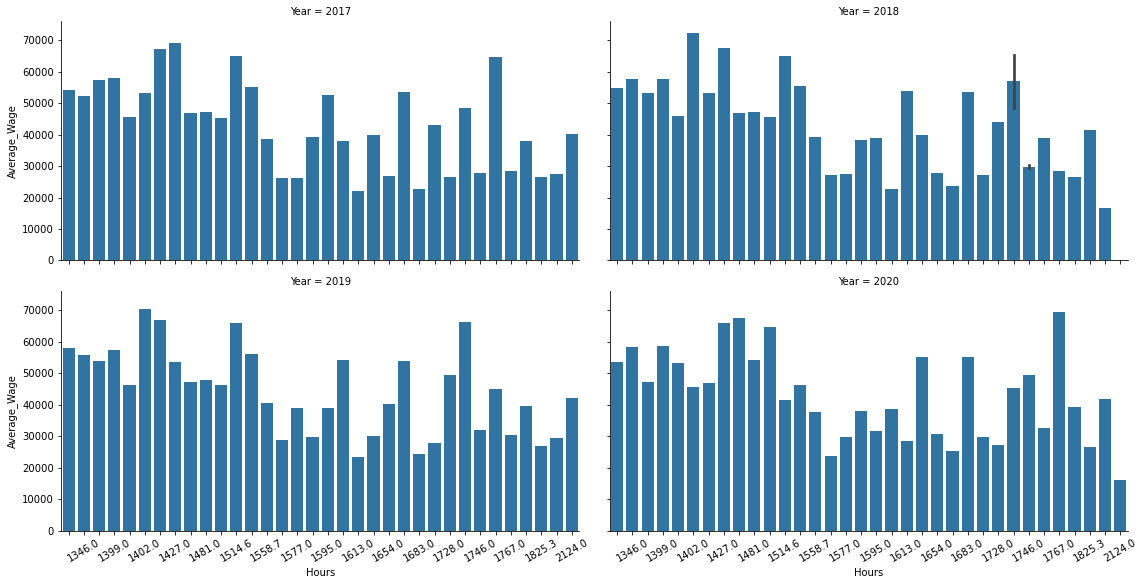

In [55]:
g = sb.FacetGrid(data=df,col='Year',col_wrap=2,size=4,aspect=2)
g.map(sb.barplot,'Hours','Average_Wage');
for ax in g.axes.flat:
    labels = ax.get_xticklabels() # get x labels
    for i,l in enumerate(labels):
        if(i%2 == 0): labels[i] = '' # skip even labels
    ax.set_xticklabels(labels, rotation=30) # set new labels

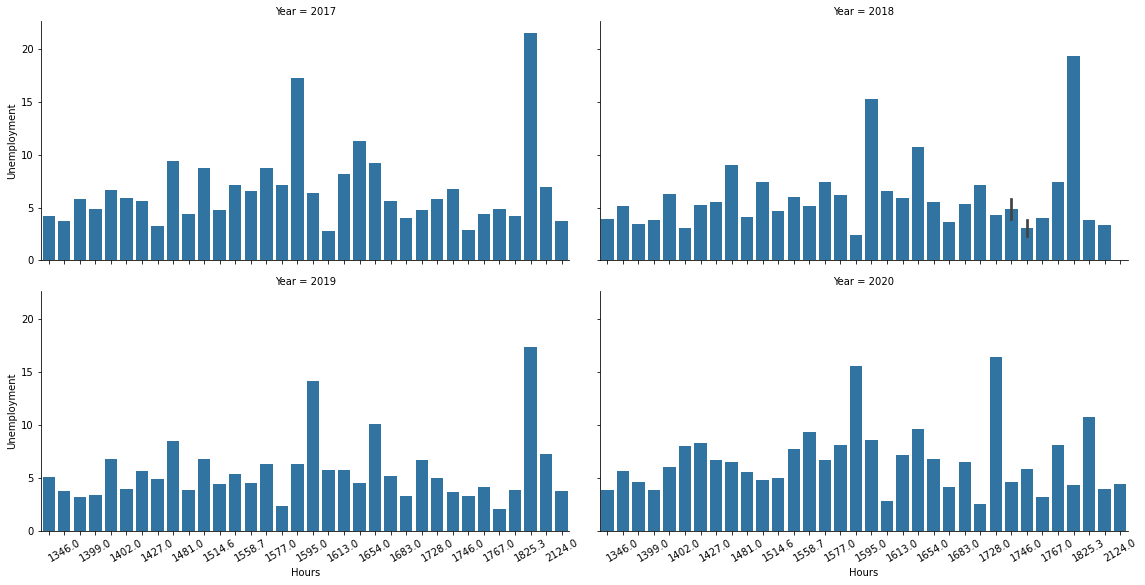

In [57]:
g = sb.FacetGrid(data=df,col='Year',col_wrap=2,size=4,aspect=2)
g.map(sb.barplot,'Hours','Unemployment');
for ax in g.axes.flat:
    labels = ax.get_xticklabels() # get x labels
    for i,l in enumerate(labels):
        if(i%2 == 0): labels[i] = '' # skip even labels
    ax.set_xticklabels(labels, rotation=30) # set new labels


The three figures up there showing the relationship between the hours and different aspects over the last 4 years show some really interesting points : 

    1- The highest GDP isn't associated with the highest working hours rather it's better when the working hours are moderate.
    
    2- The highest wages weren't for the people with the most working hours but also at a moderate working hours.
    
    3- The unemployment rate was much higher when the working hours increased showing the negative effects it can have on both economy and employee as the working hours increase.

# CONCLUSIONS

1 - We have seen the relationship between working hours,GDP,average wages and unemployment rate which shows that the working hours don't really affect the GDP that much but they affect the average wages negatively as well as affecting the unemployment rates by raising them significantly, which shows that poorer countries have a very high working hours with very low wages while others have the biggest share of the wages, employing less, giving more workload to employers while paying them less. 

2 - The highest average wages were associated with a moderate to low number of working hours which suggests that overload in work actually harms the worker as with higher working hours the wages are lower, not contributing much to the GDP nor being very productive. 